# Exploratory Data Analysis #

In [16]:
!pip install -r requirements.txt

In [12]:
import pandas as pd
import re
import contractions
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# load data 
data = pd.read_csv('data/Combined_data.csv')

In [3]:
# convert statement col to string
data['statement'] = data['statement'].astype(str)


In [4]:
def summarize_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Summarizes the given DataFrame by providing key statistics for each column.

    Parameters:
    df (pd.DataFrame): The DataFrame to summarize.

    Returns:
    pd.DataFrame: A summary DataFrame containing statistics for each column.
    """
    summary = pd.DataFrame({
        'Data Type': df.dtypes,
        'Non-Null Count': df.notnull().sum(),
        'Unique Values': df.nunique(),
        'Mean': df.select_dtypes(include=['number']).mean(),
        'Median': df.select_dtypes(include=['number']).median(),
        'Min': df.select_dtypes(include=['number']).min(),
        'Max': df.select_dtypes(include=['number']).max(),
        'Std Dev': df.select_dtypes(include=['number']).std()
    })

    return summary

In [5]:
"""
a. Load & Inspect

Check for missing or duplicate Statement entries.

Examine class distribution and total record count.

Compute text length statistics (tokens per post, characters).
"""
missing_data = data['statement'].isnull().sum()
duplicate_data = data['statement'].duplicated().sum()
class_distribution = data['status'].value_counts()
total_records = len(data)

print("Missing data:")
print(missing_data)

print("Duplicate data:")
print(duplicate_data)

print("Class distribution:")
print(class_distribution)

print("Total records:")
print(total_records)


Missing data:
0
Duplicate data:
1969
Class distribution:
status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64
Total records:
53043


In [13]:

"""
b. Cleaning

Lowercasing, remove URLs, emojis, punctuation.

Expand contractions (e.g., “don’t → do not”).

Optional: lemmatize for LDA pipeline.
"""

def clean_text(text: str, lemmatize: bool = False) -> str:
    """
    Cleans the input text by lowercasing, removing URLs, emojis, punctuation,
    expanding contractions, and optionally lemmatizing.

    Parameters:
    text (str): The text to clean.

    Returns:
    str: The cleaned text.
    """

    # Lowercase
    # print("text: ", text)
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove emojis
    text = text.encode('ascii', 'ignore').decode('ascii')
    
    # Expand contractions
    text = contractions.fix(text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenize
    tokens = nltk.word_tokenize(text)
    
    return ' '.join(tokens)

data['cleaned_statement'] = data['statement'].apply(lambda x: clean_text(x))
print(data[['statement', 'cleaned_statement']].head())  
                

                                           statement  \
0                                         oh my gosh   
1  trouble sleeping, confused mind, restless hear...   
2  All wrong, back off dear, forward doubt. Stay ...   
3  I've shifted my focus to something else but I'...   
4  I'm restless and restless, it's been a month n...   

                                   cleaned_statement  
0                                         oh my gosh  
1  trouble sleeping confused mind restless heart ...  
2  all wrong back off dear forward doubt stay in ...  
3  i have shifted my focus to something else but ...  
4  i am restless and restless it is been a month ...  


In [17]:
data.to_csv('data/cleaned_data.csv', index = False)

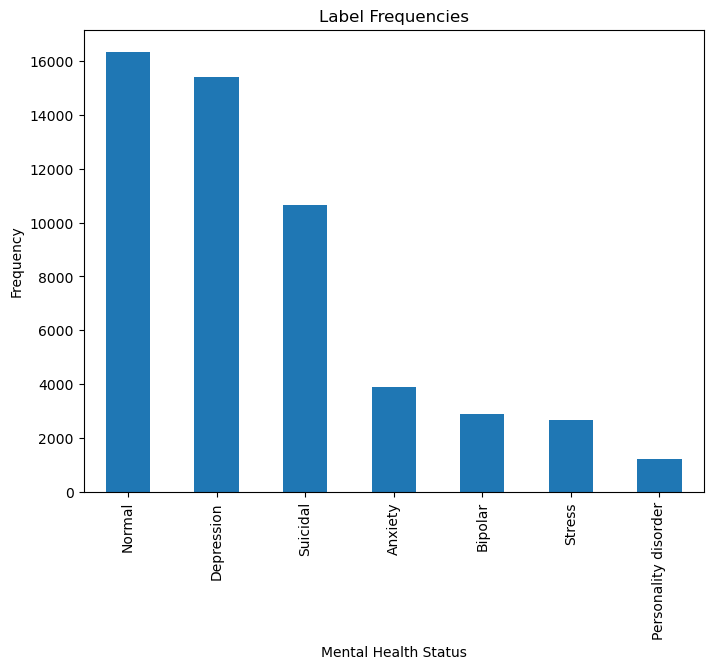

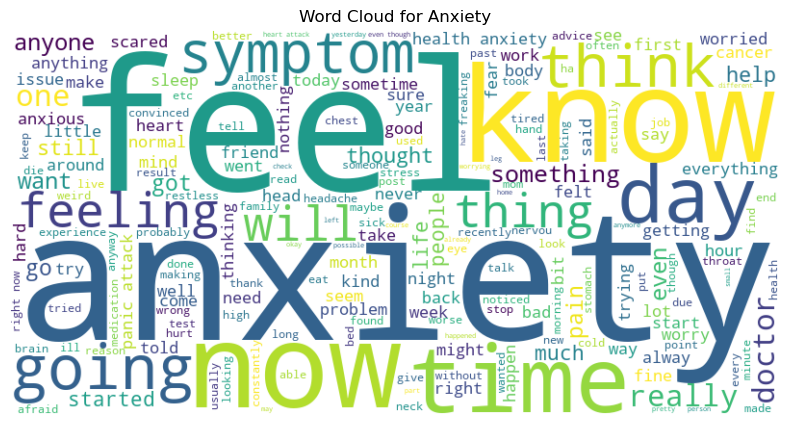

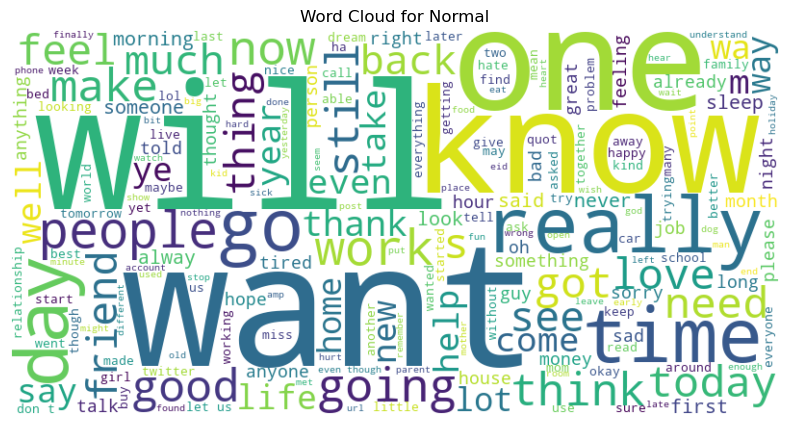

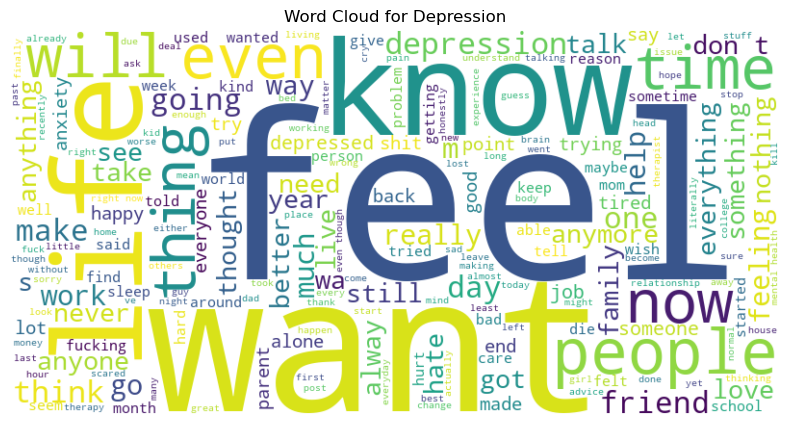

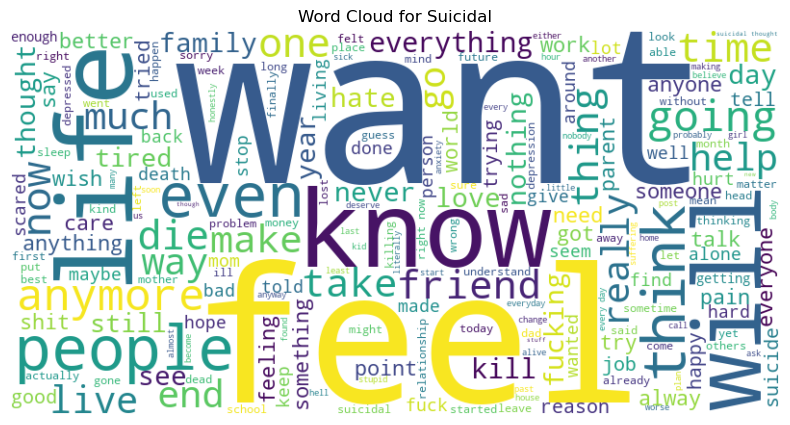

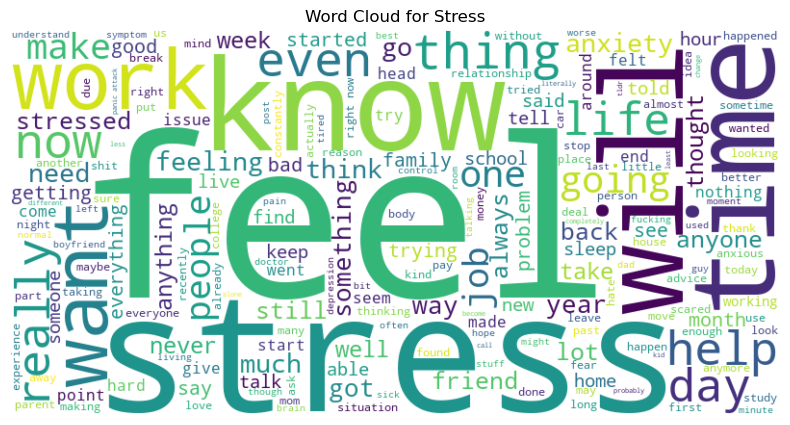

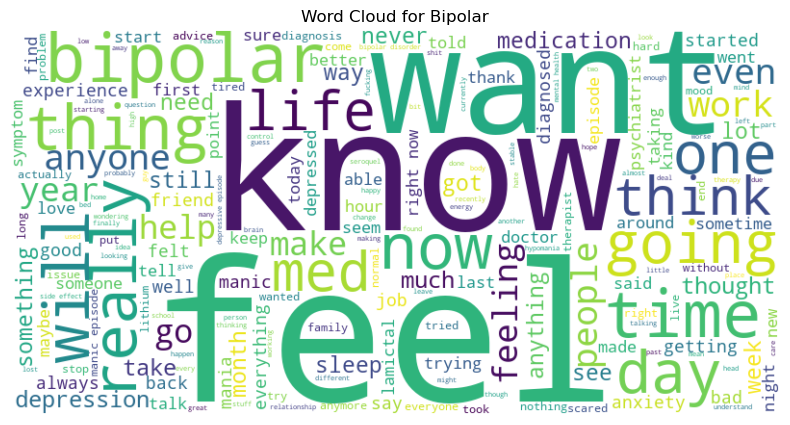

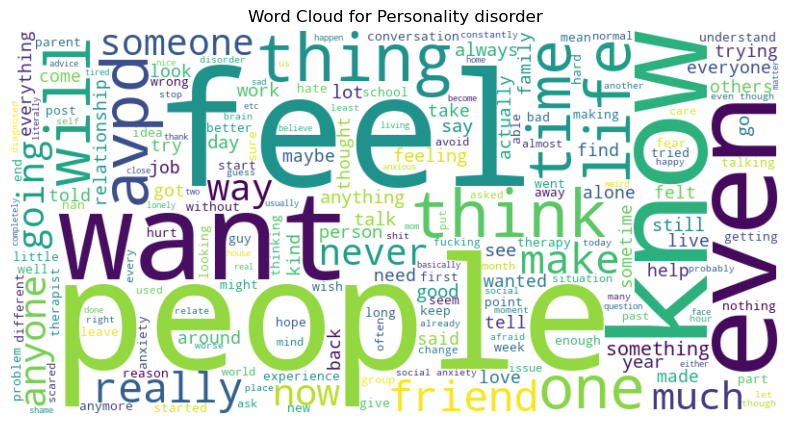

Top TF-IDF keywords for Anxiety:
anxiety    0.236750
just       0.203841
like       0.191346
feel       0.149065
know       0.144707
really     0.122161
time       0.116965
going      0.104330
feeling    0.094375
did        0.091743
dtype: float64


Top TF-IDF keywords for Normal:
just      0.057820
like      0.053620
want      0.052478
really    0.037851
time      0.035992
did       0.035204
good      0.032789
know      0.032104
day       0.029966
people    0.027537
dtype: float64


Top TF-IDF keywords for Depression:
just          0.268985
like          0.216032
feel          0.206519
want          0.171439
know          0.164198
life          0.162360
depression    0.155923
time          0.127114
people        0.120419
really        0.114190
dtype: float64


Top TF-IDF keywords for Suicidal:
just       0.268325
want       0.226463
like       0.176851
life       0.174133
know       0.157419
feel       0.155115
going      0.119043
people     0.116931
time       0.102585
anymore    0.0

In [15]:
"""c. Exploration

Bar chart of label frequencies (to reveal imbalance).

Word clouds / top n-grams per category.

TF-IDF keyword comparison across classes."""

# Bar chart of label frequencies
label_counts = data['status'].value_counts()
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar')
plt.title('Label Frequencies')
plt.xlabel('Mental Health Status')
plt.ylabel('Frequency')
plt.show()

# Word cloud for each category
categories = data['status'].unique()
for category in categories:
    subset = data[data['status'] == category]
    text = ' '.join(subset['cleaned_statement'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {category}')
    plt.axis('off')
    plt.show() 
# TF-IDF keyword comparison across classes
tfidf = TfidfVectorizer(max_features=10, stop_words='english')
for category in categories:
    subset = data[data['status'] == category]
    tfidf_matrix = tfidf.fit_transform(subset['cleaned_statement'])
    feature_names = tfidf.get_feature_names_out()
    dense = tfidf_matrix.todense()
    denselist = dense.tolist()
    df_tfidf = pd.DataFrame(denselist, columns=feature_names)
    mean_tfidf = df_tfidf.mean().sort_values(ascending=False)
    
    print(f'Top TF-IDF keywords for {category}:')
    print(mean_tfidf.head(10))
    print('\n')